In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv
/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv


In [2]:
!pip install google-cloud-translate

In [3]:
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import plot_confusion_matrix
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install nltk
import nltk
!pip install numpy requests nlpaug
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 17.0 MB/s eta 0:00:00


In [4]:
# from google.cloud import translate_v2 as translate

# translate_client = translate.Client.from_service_account_json('/kaggle/input/key-translator/micro-atrium-368104-e24b1f445501.json')


In [5]:
# df=pd.read_csv("/kaggle/input/hindi-data/Hindi_pos-neg dataset-train.csv")
# df2 = pd.read_csv("/kaggle/input/eng-data-review/eng-data-train.csv",encoding='unicode_escape')
# df3 = pd.read_csv("/kaggle/input/hindi-train/hindi_train.csv",encoding='unicode_escape')

df1=pd.read_csv("/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv")
df1=df1[0:5000]


In [6]:
# mkdir nltk_data
# python -m nltk.downloader
# nltk.download("wordnet","/nltk_data/")
# nltk.download("wordnet")

In [7]:
# nltk.download("wordnet", "whatever_the_absolute_path_to_myapp_is/nltk_data/")
# text = 'आपकी राशि से चंद्रमा दूसरे भाव में है'
# aug = naw.SynonymAug(aug_src='wordnet', lang='hi')
# augmented_text = aug.augment(text)
# print("Original:")
# print(text)
# print("Augmented Text:")
# print(augmented_text)

In [8]:

# to append df2 at the end of df1 dataframe
# df.append(df2)
# # df2
# df= pd.concat([df, df3], axis=0)
# # df1['text'][477]
# df

In [9]:
# text = 'Bonjour tout le monde'

# for ind in range(1):
#     result = translate_client.translate(text, target_language='en')
# #     df1.loc['text'][ind]=result
# #     df.loc[ind, 'text'] = result['translatedText']
# #     df1 = pd.DataFrame({"text":result,"experience":df['experience'][ind]})

#     print(result['translatedText'])


# # print(result['input'])
# # print(result['translatedText'])


In [10]:
df1.isnull().any()

text     False
label    False
dtype: bool

Text(0.5, 1.0, 'Labels')

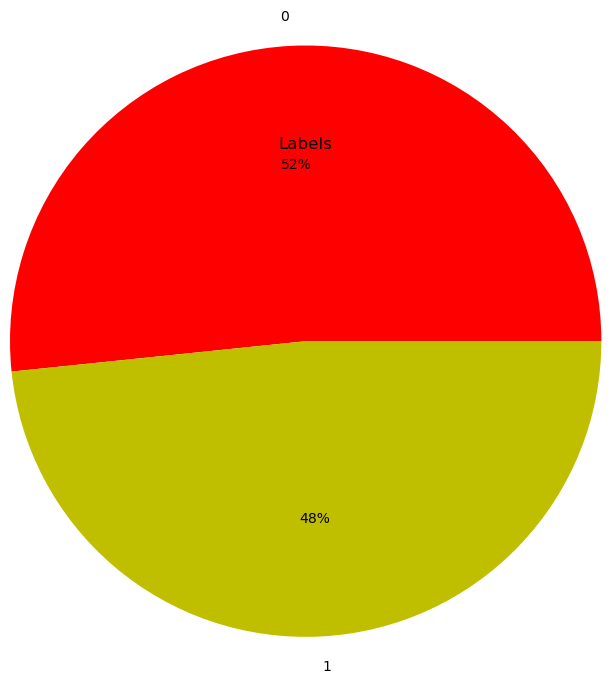

In [11]:
plt.pie(df1["label"].value_counts(),autopct='%1.0f%%',radius=2,labels=df1["label"].unique(),colors=["r","y"])
plt.title("Labels")

In [12]:
review500=df1["text"][500]
print(review500)
# review34

Just because an event really happened doesn't mean that it will make a good screenplay/ movie. The Cat's Meow, by Peter Bogdanovich claims to be based on actual events which happened on a cruise hosted by William Randolph Hurst. The writer paid more attention to creating a bizarre cast of characters than taking time to create a story for the bizarre characters to inhabit. The key moments of the story seem implausible; for example, when Hurst accidentally shoots the producer, believing him to be Chaplin. Basing a key element of a story on someone wearing the wrong hat is trite and contrived. The story attempts to be a dark comedy, but The Cat's Meow misses an important piece of this equation, comedy. There is also a lack of empathy for any of the characters. It hardly matters who is shot, who is killed, who is guilty and who is innocent. There is not a strong character to cheer for. As a result the conflicts are difficult to care about and the eventual outcome is incidental.


In [13]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
print(stop_words)

{'be', 'won', 'does', "aren't", 'he', 'what', 'those', 'haven', 'who', 'until', "you're", "you've", "doesn't", "isn't", 'to', 'ourselves', 'you', 'his', 'that', 'by', "haven't", 'below', 'from', 'up', 'so', 'again', 'nor', "you'd", 'just', 'where', 'himself', 'myself', 'for', 'doesn', 'its', 'll', 'yourself', 'on', 'when', "mightn't", "won't", 'their', 'between', "she's", 'is', 'further', 'it', "it's", 'both', 'own', 'too', 've', 'hadn', 'down', 'against', 'weren', 'with', 'or', 'if', 'can', 'we', "should've", 'into', 'most', 'y', 'having', 'her', 'some', 'were', "don't", 're', 'hasn', 'me', "shouldn't", 'before', 'o', 'mustn', 'there', 'not', "didn't", 'theirs', 'are', 'than', 'couldn', 'm', 'an', 'which', 'only', 'yourselves', 'how', "mustn't", 's', 'they', 'very', 'during', 'shan', 'under', 'your', 'will', "shan't", 'off', 'each', 'don', 'why', 'ours', 'hers', "that'll", 'doing', 'all', 'at', 'no', 'same', 'and', 'but', "hasn't", 'while', 'shouldn', 'about', 'our', "hadn't", 'been',

In [15]:
#let us remove word not from stop words, since it is the one of the most important word in classifing the review.
stop_words.remove("not")

In [16]:
def text_Preprocessing(reviews):
    
    
    """ This will clean the text data, remove html tags, remove special characters and then tokenize the reviews to apply Stemmer on each word token."""
    
    pre_processed_reviews=[]
    
    for review in tqdm(reviews):
        review= BeautifulSoup(review,'lxml').getText()    #remove html tags
        review=re.sub('\S*\d\S*','',review).strip()
        review=re.sub('[^A-Za-z]+',' ',review)        #remove special chars
        review=re.sub("n't","not",review)
        review=word_tokenize(str(review.lower())) #tokenize the reviews into word tokens

        # now we will split the review into words and then check if these words are in the stop words if so we will remove them, if not we will join
        review=' '.join(PorterStemmer().stem(word) for word in review if word not in stop_words)
        pre_processed_reviews.append(review.strip())
    return pre_processed_reviews

In [17]:
preprocessed_reviews=text_Preprocessing(df1["text"])
preprocessed_reviews[500]

 10%|█         | 512/5000 [00:04<00:38, 116.69it/s]/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 5000/5000 [00:40<00:00, 122.00it/s]


'event realli happen mean make good screenplay movi cat meow peter bogdanovich claim base actual event happen cruis host william randolph hurst writer paid attent creat bizarr cast charact take time creat stori bizarr charact inhabit key moment stori seem implaus exampl hurst accident shoot produc believ chaplin base key element stori someon wear wrong hat trite contriv stori attempt dark comedi cat meow miss import piec equat comedi also lack empathi charact hardli matter shot kill guilti innoc not strong charact cheer result conflict difficult care eventu outcom incident'

In [18]:
preprocessed_reviews=pd.DataFrame({"text":preprocessed_reviews,"sentiment":df1.label})
preprocessed_reviews.head()

,text,sentiment
0,grew b watch love thunderbird mate school watc...,0
1,put movi dvd player sat coke chip expect hope ...,0
2,peopl not know particular time past like feel ...,0
3,even though great interest biblic movi bore de...,0
4,im die hard dad armi fan noth ever chang got t...,1


In [19]:
preprocessed_reviews.sentiment.value_counts()

0    2582
1    2418
Name: sentiment, dtype: int64

Observations:
1. we cleaned our text data, removed unnecessary tags
2. Though we cleaned our data, it is still in string format which computers won't understand, for this we use text featuration.

### Featurization

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
reviews_train,reviews_test,sentiment_train,sentiment_test=train_test_split(preprocessed_reviews.text,preprocessed_reviews.sentiment)
print(reviews_train.shape,reviews_test.shape)
print(sentiment_train.shape,sentiment_test.shape)

(3750,) (1250,)
(3750,) (1250,)


In [22]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=6000)
tfidf_model.fit(reviews_train,sentiment_train)
reviews_train_tfidf=tfidf_model.transform(reviews_train)
reviews_test_tfidf=tfidf_model.transform(reviews_test)
reviews_train_tfidf.shape,reviews_test_tfidf.shape
# tfidf_vector_X = vectorizer.transform(X).toarray()  #//shape - (3,6)
# tfidf_vector_Y = vectorizer.transform(Y).toarray()
# tfidf_vector_X = tfidf_vector_X[:, :, None] #shape - (3,6,1) since LSTM cells expects ndims = 3
# tfidf_vector_Y = tfidf_vector_Y[:, :, None] #shape - (3,6,1)


((3750, 6000), (1250, 6000))

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(reviews_train)

In [24]:
train_sequences = token.texts_to_sequences(reviews_train)
valid_sequences = token.texts_to_sequences(reviews_test)

In [25]:
vocab_size = len(token.word_index)+1
vocab_size

22808

In [26]:
maxlen=100

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(train_sequences, maxlen=maxlen,padding = 'post')
X_test = pad_sequences(valid_sequences, maxlen=maxlen,padding = 'post')

In [28]:
tfidf_df=pd.DataFrame(reviews_train_tfidf.toarray(),columns=tfidf_model.get_feature_names(),index=reviews_train.index)
tfidf_df

,abandon,abc,abduct,abil,abl,aboard,absenc,absolut,absolut love,absolut noth,...,young kid,young man,young woman,younger,youngest,youth,youtub,zero,zombi,zone
3518,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1872,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4264,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.043916,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3965,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.109597,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
429,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.042622,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4422,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Lets checkout the top features
top_features=sorted(zip(tfidf_model.idf_,tfidf_model.get_feature_names()))
top10=top_features[:10]

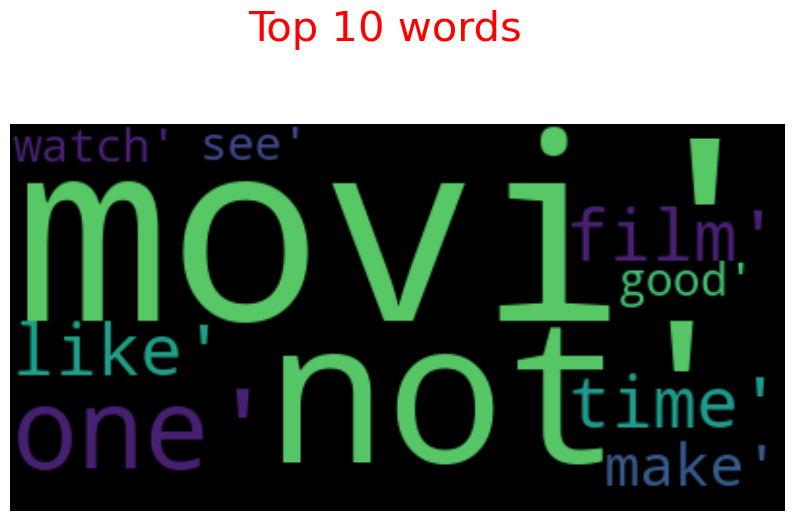

In [30]:
from wordcloud import WordCloud
plt.figure(figsize=(10,8))
wc = WordCloud(background_color="black",max_font_size=150, random_state=42)
wc.generate(str(top10))
plt.imshow(wc, interpolation='bilinear')
plt.suptitle('Top 10 words', size=30, y=0.88,color="r"); 
plt.axis("off")
plt.savefig("top10_words.png")
plt.show()

# Modeling

In [31]:
from imblearn.over_sampling import SMOTE
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_resample(reviews_train_tfidf,sentiment_train)
oversampled_trainY.value_counts()

1    1966
0    1966
Name: sentiment, dtype: int64

## Support Vector Classifier

In [32]:
svc_model=SVC(C=1,kernel='rbf', max_iter=1000)
svc_model.fit(oversampled_trainX,oversampled_trainY)
svc_predict=svc_model.predict(reviews_test_tfidf)
svc_f1=f1_score(sentiment_test,svc_predict,average="weighted")
svc_f1

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


0.8623873141074726

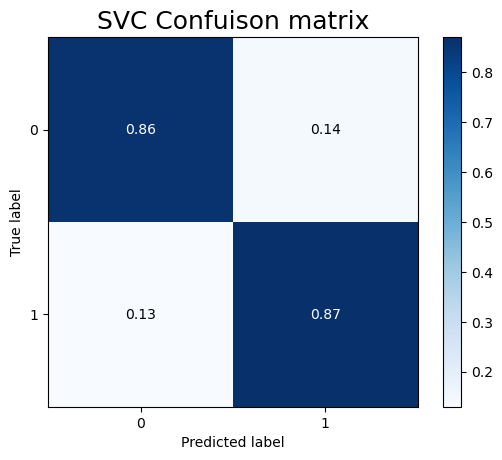

In [33]:
plot_confusion_matrix(sentiment_test,svc_predict,normalize=True)
plt.title("SVC Confuison matrix",size=18)
plt.show()

## Naive Bayes:

In [34]:
nb_params={"alpha":[10**i for i in range(-5,5)]}
nb_clf=MultinomialNB()
rndm_clf=RandomizedSearchCV(nb_clf,nb_params)
rndm_clf.fit(oversampled_trainX,oversampled_trainY)
nb_best_params=rndm_clf.best_params_

nb_clf=MultinomialNB(**nb_best_params)
nb_clf.fit(oversampled_trainX,oversampled_trainY)
nb_predict=nb_clf.predict(reviews_test_tfidf)
nb_f1=f1_score(sentiment_test,nb_predict,average="weighted")
nb_f1

0.8455510519651777

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

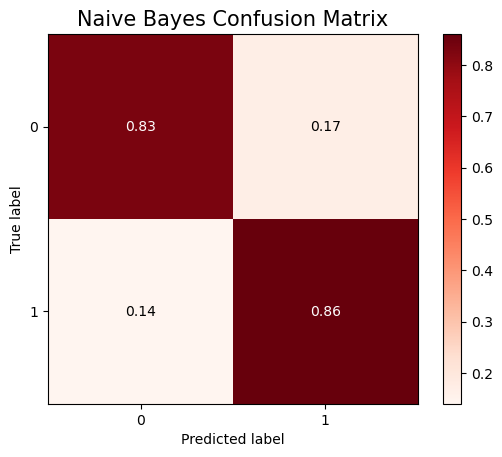

In [35]:
plot_confusion_matrix(sentiment_test,nb_predict,normalize=True,cmap="Reds")
plt.title("Naive Bayes Confusion Matrix",size=15)

## LSTM

In [36]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 200,input_length=maxlen,trainable = False))
model.add(LSTM(64,return_sequences=True,dropout=0.2, recurrent_dropout=0.4))
model.add(GlobalMaxPooling1D())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          4561600   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           67840     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

In [38]:
history = model.fit(X_train,sentiment_train,batch_size=128,epochs=45,verbose=1,callbacks=[es,mc])

Epoch 1/45
30/30 [==============================] - 17s 373ms/step - loss: 0.6913 - accuracy: 0.5296
Epoch 2/45
30/30 [==============================] - 11s 377ms/step - loss: 0.6830 - accuracy: 0.5499
Epoch 3/45
30/30 [==============================] - 12s 406ms/step - loss: 0.6495 - accuracy: 0.6344
Epoch 4/45
30/30 [==============================] - 11s 375ms/step - loss: 0.6265 - accuracy: 0.6645
Epoch 5/45
30/30 [==============================] - 11s 377ms/step - loss: 0.6165 - accuracy: 0.6741
Epoch 6/45
30/30 [==============================] - 12s 404ms/step - loss: 0.5914 - accuracy: 0.6893
Epoch 7/45
30/30 [==============================] - 12s 385ms/step - loss: 0.5774 - accuracy: 0.7075
Epoch 8/45
30/30 [==============================] - 12s 411ms/step - loss: 0.5724 - accuracy: 0.7080
Epoch 9/45
30/30 [==============================] - 11s 379ms/step - loss: 0.5554 - accuracy: 0.7259
Epoch 10/45
30/30 [==============================] - 11s 378ms/step - loss: 0.5402 - accura

In [39]:
score_lstm = model.evaluate(X_test,sentiment_test)

40/40 [==============================] - 1s 25ms/step - loss: 0.5002 - accuracy: 0.7720


## BI-LSTM

In [40]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 200,input_length=maxlen,trainable = False))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2, recurrent_dropout=0.4)))
model.add(GlobalMaxPooling1D())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 200)          4561600   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         135680    
 l)                                                              
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [41]:
history = model.fit(X_train,sentiment_train,batch_size=128,epochs=35,verbose=1,callbacks=[es,mc])

Epoch 1/35
30/30 [==============================] - 29s 756ms/step - loss: 0.6922 - accuracy: 0.5205
Epoch 2/35
30/30 [==============================] - 23s 772ms/step - loss: 0.6901 - accuracy: 0.5237
Epoch 3/35
30/30 [==============================] - 23s 770ms/step - loss: 0.6719 - accuracy: 0.5856
Epoch 4/35
30/30 [==============================] - 22s 743ms/step - loss: 0.6410 - accuracy: 0.6331
Epoch 5/35
30/30 [==============================] - 23s 766ms/step - loss: 0.6365 - accuracy: 0.6595
Epoch 6/35
30/30 [==============================] - 23s 759ms/step - loss: 0.6117 - accuracy: 0.6725
Epoch 7/35
30/30 [==============================] - 23s 755ms/step - loss: 0.5966 - accuracy: 0.6875
Epoch 8/35
30/30 [==============================] - 23s 763ms/step - loss: 0.5805 - accuracy: 0.7051
Epoch 9/35
30/30 [==============================] - 23s 769ms/step - loss: 0.5449 - accuracy: 0.7221
Epoch 10/35
30/30 [==============================] - 22s 747ms/step - loss: 0.5364 - accura

In [42]:
score_bilstm = model.evaluate(X_test,sentiment_test)

40/40 [==============================] - 3s 63ms/step - loss: 0.4831 - accuracy: 0.7576


In [43]:
from sklearn.linear_model import SGDClassifier
clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, l1_ratio=0.15, max_iter=1000, tol=0.001, learning_rate='optimal')
clf.fit(oversampled_trainX,oversampled_trainY)
y_pred = clf.predict(reviews_test_tfidf)

In [44]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(sentiment_test, y_pred))

Accuracy: 0.8664
